Przeprowadzić analizę mocy wybranych testów statystycznych w różnych warunkach. Badaniu poddane zostaną testy Kołmogorowa, Lillieforsa, Andersona-Darlinga oraz test Kołmogorowa-Smirnowa, zarówno w klasycznej wersji, jak i z wykorzystaniem transformacji PIT (probability integral transform).

# Zdanie 1
Wpływ rozkładu danych na moc testów 
Zbadanie mocy testów w przypadku, gdy dane pochodzą z różnych rozkładów:

- Rozkład t-Studenta (z uwzględnieniem liczby stopni swobody),
- Rozkład χ2 (z uwzględnieniem liczby stopni swobody),
- Rozkłady normalne o różnych odchyleniach standardowych przy stałej wartości oczekiwanej,
- Rozkłady NIG i gamma o różnych parametrach.

Uwaga dotycząca testów:
- Wersja klasyczna zakłada, że testujemy H0 "dane pochodzą z rozkładu F" przy użyciu dystrybuanty F,
- W wersji PIT najpierw przekształcam dane, dla każdego x liczymy F(x), dzięki czemu pod H0 otrzymuje rozkład jednostajny U(0,1). Testy realizuje wtedy względem rozkładu jednostajnego.
- Dla testu Lillieforsa (przeznaczony do badania normalności przy estymacji parametrów) wykorzystuje pakiet statsmodels. Ponieważ nie ma powszechnej wersji Lillieforsa dla U(0,1), w wariancie PIT wykorzystam standardowy test KS, czyli porównanie z U(0,1).
- Anderson–Darling nie zwraca p‑wartości; uznaje, że H0 odrzucam, gdy statystyka przekracza krytyczną wartość odpowiadającą poziomowi 5%.

In [15]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parametry do ustawienia
# sample_size = 100  # Rozmiar próbki
# n_simulations = 1000  # Liczba powtórzeń
sample_size = 500  # Rozmiar próbki
n_simulations = 800  # Liczba powtórzeń

# Lista rozkładów (każdy jako słownik: nazwa, generator, CDF do PIT)
distributions = [
    {
        "name": "t_Student",
        "generator": lambda: stats.t.rvs(df=5, size=sample_size),
        "cdf": lambda x: stats.t.cdf(x, df=5)
    },
    {
        "name": "chi2",
        "generator": lambda: stats.chi2.rvs(df=5, size=sample_size),
        "cdf": lambda x: stats.chi2.cdf(x, df=5)
    },
    {
        "name": "normal_std_2",
        "generator": lambda: np.random.normal(loc=0, scale=2, size=sample_size),
        "cdf": lambda x: stats.norm.cdf(x, loc=0, scale=2)
    },
    {
        "name": "gamma",
        "generator": lambda: stats.gamma.rvs(a=2, scale=2, size=sample_size),
        "cdf": lambda x: stats.gamma.cdf(x, a=2, scale=2)
    },
    # NIG – tu możesz podstawić własną funkcję jeśli masz bibliotekę np. `pyNIG`
    {
        "name": "nig_approx",
        "generator": lambda: np.random.normal(loc=0, scale=1, size=sample_size),  # Placeholder
        "cdf": lambda x: stats.norm.cdf(x)
    }
]

# Funkcja do transformacji PIT
def apply_pit(sample, cdf_func):
    return np.sort(cdf_func(np.sort(sample)))

# Zbiór testów do wykonania
def run_tests(sample, pit_sample):
    results = {}

    # Test Kołmogorowa
    results["kolmogorov"] = stats.kstest(sample, "norm").statistic
    results["kolmogorov_pit"] = stats.kstest(pit_sample, "uniform").statistic

    # Test Lillieforsa (poprzez kstest z normalizacją)
    standardized = (sample - np.mean(sample)) / np.std(sample, ddof=1)
    results["lilliefors"] = stats.kstest(standardized, "norm").statistic

    pit_standardized = (pit_sample - np.mean(pit_sample)) / np.std(pit_sample, ddof=1)
    results["lilliefors_pit"] = stats.kstest(pit_standardized, "uniform").statistic

    # Anderson-Darling tylko dla klasycznej wersji
    results["anderson"] = stats.anderson(sample, dist='norm').statistic

    # Test Kołmogorowa-Smirnowa dla dwóch próbek
    ref_normal = np.random.normal(loc=0, scale=1, size=sample_size)
    ref_uniform = np.random.uniform(0, 1, size=sample_size)
    results["ks_2samp"] = stats.ks_2samp(sample, ref_normal).statistic
    results["ks_2samp_pit"] = stats.ks_2samp(pit_sample, ref_uniform).statistic

    return results

# Główna pętla: symulacja + testy
all_results = {}

for dist in distributions:
    dist_name = dist["name"]
    # print(f"Przetwarzanie: {dist_name}")
    test_results = {
        "kolmogorov": [],
        "kolmogorov_pit": [],
        "lilliefors": [],
        "lilliefors_pit": [],
        "anderson": [],
        "ks_2samp": [],
        "ks_2samp_pit": [],
    }

    for _ in tqdm(range(n_simulations)):
        sample = dist["generator"]()
        pit_sample = apply_pit(sample, dist["cdf"])

        result = run_tests(sample, pit_sample)
        for key in test_results:
            test_results[key].append(result[key])

    all_results[dist_name] = test_results

100%|██████████| 800/800 [00:03<00:00, 260.01it/s]



t_Student
kolmogorov: Moc testu = 0.50
kolmogorov_pit: Moc testu = 0.84
lilliefors: Moc testu = 0.35
lilliefors_pit: Moc testu = 0.00
anderson: Średnia statystyka = 2.799
ks_2samp: Moc testu = 0.19
ks_2samp_pit: Moc testu = 0.47

chi2
kolmogorov: Moc testu = 0.00
kolmogorov_pit: Moc testu = 0.85
lilliefors: Moc testu = 0.00
lilliefors_pit: Moc testu = 0.00
anderson: Średnia statystyka = 9.505
ks_2samp: Moc testu = 0.00
ks_2samp_pit: Moc testu = 0.45

normal_std_2
kolmogorov: Moc testu = 0.00
kolmogorov_pit: Moc testu = 0.86
lilliefors: Moc testu = 1.00
lilliefors_pit: Moc testu = 0.00
anderson: Średnia statystyka = 0.388
ks_2samp: Moc testu = 0.00
ks_2samp_pit: Moc testu = 0.42

gamma
kolmogorov: Moc testu = 0.00
kolmogorov_pit: Moc testu = 0.85
lilliefors: Moc testu = 0.00
lilliefors_pit: Moc testu = 0.00
anderson: Średnia statystyka = 11.882
ks_2samp: Moc testu = 0.00
ks_2samp_pit: Moc testu = 0.43

nig_approx
kolmogorov: Moc testu = 0.85
kolmogorov_pit: Moc testu = 0.85
lilliefors:

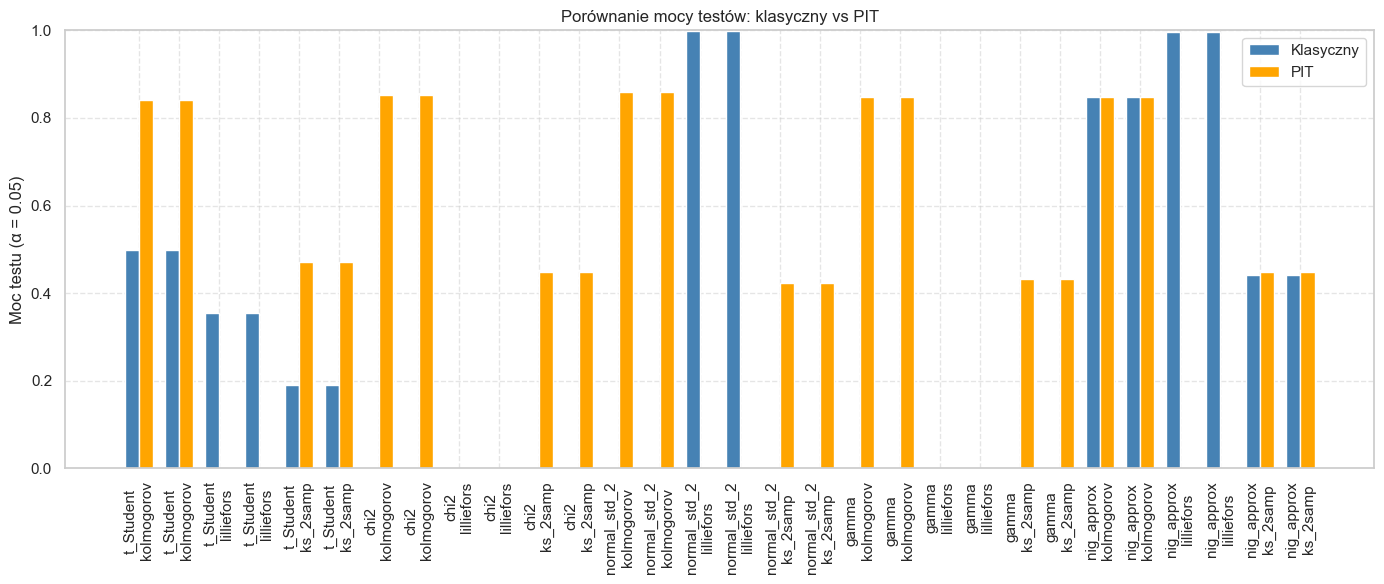

In [16]:
for dist_name, results in all_results.items():
    print(f"\n{dist_name}")
    for test_name, values in results.items():
        if "anderson" in test_name:
            mean_stat = np.mean(values)
            print(f"{test_name}: Średnia statystyka = {mean_stat:.3f}")
        else:
            power = np.mean(np.array(values) < 0.05)
            print(f"{test_name}: Moc testu = {power:.2f}")

# def plot_power_comparison(all_results):
#     for dist_name, results in all_results.items():
#         for test_name in results:
#             # Pomijamy Andersona-Darlinga z PIT (nieistnieje)
#             if test_name == "anderson_pit":
#                 continue

#             base_test_name = test_name.replace("_pit", "")
#             pit_test_name = base_test_name + "_pit"

#             # Upewnijmy się, że mamy obie wersje testu
#             if base_test_name not in results or pit_test_name not in results:
#                 continue

#             # Oblicz moc testu
#             base_power = np.mean(np.array(results[base_test_name]) < 0.05)
#             pit_power = np.mean(np.array(results[pit_test_name]) < 0.05)

#             # Wykres
#             plt.figure(figsize=(5, 4))
#             plt.bar(["Klasyczny", "PIT"], [base_power, pit_power], color=["steelblue", "orange"])
#             plt.ylim(0, 1)
#             plt.ylabel("Moc testu (α = 0.05)")
#             plt.title(f"{dist_name} – {base_test_name}")
#             plt.grid(True, linestyle="--", alpha=0.5)
#             plt.tight_layout()
#             plt.show()
            
# plot_power_comparison(all_results)
def plot_power_comparison_grouped(all_results):
    labels = []
    base_powers = []
    pit_powers = []

    for dist_name, results in all_results.items():
        for test_name in results:
            # Pomijamy Andersona z PIT, bo nie istnieje
            if test_name == "anderson_pit":
                continue

            base_test_name = test_name.replace("_pit", "")
            pit_test_name = base_test_name + "_pit"

            # Upewniamy się, że obie wersje testu istnieją
            if base_test_name not in results or pit_test_name not in results:
                continue

            base_power = np.mean(np.array(results[base_test_name]) < 0.05)
            pit_power = np.mean(np.array(results[pit_test_name]) < 0.05)

            labels.append(f"{dist_name}\n{base_test_name}")
            base_powers.append(base_power)
            pit_powers.append(pit_power)

    # Tworzenie grupowanego wykresu słupkowego
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width/2, base_powers, width, label='Klasyczny', color='steelblue')
    ax.bar(x + width/2, pit_powers, width, label='PIT', color='orange')

    ax.set_ylabel("Moc testu (α = 0.05)")
    ax.set_title("Porównanie mocy testów: klasyczny vs PIT")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Wywołanie
plot_power_comparison_grouped(all_results)

## Interpretacja wyników

**t_Student**
- t-Student przy v=3–10 może przypominać normalny rozkład (jest symetryczny, ale ma grubsze ogony).
- Testy klasyczne mają umiarkowaną moc (0.35–0.5), czyli niezbyt dobrze odróżniają t-Studenta od N(0,1).
- Po zastosowaniu PIT, testy np. Kolmogorov mają dużo większą moc (np. 0.84), bo PIT transformuje dane do [0,1], wzmacniając różnice w gęstości w ogonach.
- Moc dla Lilliefors_PIT jest 0 ponieważ bazuje na różnicy dystrybuanty empirycznej i normalnej. Po PIT dane są na przedziale [0,1] i nie są już w tej skali, test przestaje działać sensownie i dlatego moc to 0.

**chi2**
- 
https://chatgpt.com/c/67f65661-7274-8005-947c-c71536c9f494


# Zadanie 2
Wpływ liczebności danych na moc testów
Analiza mocy testów w zależności od wielkości próbki. Przeanalizować różne liczebności próbki, aby określić, jak zmienia się moc testu w miarę wzrostu liczby obserwacji.

# Zadanie 3
Analiza błędu I rodzaju
Przeprowadzenie symulacji w celu oszacowania odsetka odrzuceń prawdziwej hipotezy zerowej (błąd I rodzaju) w przypadku weryfikacji zgodności z rozkładem NIG oraz gamma. Porównanie wyników klasycznej metody testowania z metodą wykorzystującą PIT.

# Zadanie 4
Wizualizacja wyników
Wyniki analizy przedstawić w formie wykresów ilustrujących moc testów w zależności od:

- Liczebności próbki,
- Parametrów generowanych rozkładów (stopni swobody, odchylenia standardowego, parametry rozkładów NIG i gamma). Każdy wykres zostanie odpowiednio opisany i oznaczony, aby możliwa była łatwa interpretacja wyników.